# Tests

In [2]:
import numpy as np
import networkx as nx
from dwdynamics import ComplexDynamicsProblem, Objective # Difference a. We are using ComplexDynamicsProblem
import dimod
import matplotlib.pyplot as plt
import json
import os
import minorminer
from dwave_networkx.generators.pegasus import (get_tuple_defragmentation_fn, fragmented_edges,
    pegasus_coordinates, pegasus_graph)
from dwave.system import DWaveSampler, EmbeddingComposite
import matplotlib.pyplot as plt

In [5]:
def create_instance(precision, number_time_points, simplify = True):
     # We simulate evolution under the Hamiltonian 1/2 pi * Sigma_y...
    SY = np.array([[0, -1.0j], [1.0j, 0.0]])
    PSI0 = np.array([1, 0], dtype=np.complex128)  # Difference b. Initial state can now be complex.

    # The problem object encapsulates all the data so you don't have to pass them around
    problem = ComplexDynamicsProblem(
        hamiltonian=0.5 * np.pi * SY,      # Evolution under hamiltonian 0.5 * np.pi * sigma_y
        initial_state = PSI0,              # Starting at initial state |0>,
        times=tuple(range(number_time_points)),             # With six time points 0,1,2
        num_bits_per_var=precision                # And two bits of precision per variable
    )
    qubo = problem.qubo(objective=Objective.norm)  # Other choice would be to use Objective.hessian
    num_int = qubo.num_interactions + 1

    # for some reason multiple iterations over the qubo are necessary
    # to remove all 0 couplers
    if simplify:
        while (num_int > qubo.num_interactions):
            num_int = qubo.num_interactions
            for key,value in qubo.quadratic.items():
                if value == 0:
                    qubo.remove_interaction(key[0],key[1])

            
    assert qubo.num_variables == problem.hamiltonian.shape[0] * len(problem.times) * problem.num_bits_per_var * 2

    # save instances in the form 
    # systemid_{d}_precision_{d}_timepoints_{d}.json
    # systemid: {1: 0.5 * np.pi * SY}
    file_name = f"../instances/systemid_1_precision_{precision}_timepoints_{number_time_points}.json"
    with open(file_name,'w') as f:
        json.dump(qubo.to_serializable(),f)


In [13]:
create_instance(precision=3,number_time_points=6)

In [ ]:
def get_sampleset(precision,timepoints,solver_id="5.4", simplify = False):
    # We simulate evolution under the Hamiltonian 1/2 pi * Sigma_y...
    SY = np.array([[0, -1.0j], [1.0j, 0.0]])
    PSI0 = np.array([1, 0], dtype=np.complex128)  # Difference b. Initial state can now be complex.

    # The problem object encapsulates all the data so you don't have to pass them around
    problem = ComplexDynamicsProblem(
        hamiltonian=0.5 * np.pi * SY,      # Evolution under hamiltonian 0.5 * np.pi * sigma_y
        initial_state = PSI0,              # Starting at initial state |0>,
        times=tuple(range(timepoints)),             # With six time points 0,1,2
        num_bits_per_var=precision                # And two bits of precision per variable
    )
    qubo = problem.qubo(objective=Objective.norm)  # Other choice would be to use Objective.hessian
    num_int = qubo.num_interactions + 1

    if simplify:
        while (num_int > qubo.num_interactions):
            num_int = qubo.num_interactions
            for key,value in qubo.quadratic.items():
                if value == 0:
                    qubo.remove_interaction(key[0],key[1])

            
    assert qubo.num_variables == problem.hamiltonian.shape[0] * len(problem.times) * problem.num_bits_per_var * 2



    DW_TOKEN = os.getenv("DW_TOKEN")  # <- Place your token here, or use DW_TOKEN env variable, or configure D-Wave libraries to use config file


    # The graph fo the problem is pretty dense, we use automatic embedding to mitigate the incompatibility with actual machine
    if solver_id == "5.4":
        dw_sampler = EmbeddingComposite(DWaveSampler( solver="Advantage_system5.4", region="eu-central-1", ))
    elif solver_id == "zephyr": # not working yet
        print("zephyr")
        dw_sampler = EmbeddingComposite(DWaveSampler(solver=dict(id='zephyr')))


    dw_result = dw_sampler.sample(qubo, num_reads=1000, annealing_time=200)

    dw_result.first.energy
    return dw_result



In [92]:
system = 1
for solver in ["5.4"]:
    print(f"Solver {solver}")
    for i in range(0,5): # number of tests
        print(f"Iteration {i}")
        for timepoints in [3,4,5]:
            for precision in [2]:
                dw_result = get_sampleset(solver_id=solver, precision=precision,timepoints=timepoints,simplify=True)
                file_name = f"../data/results/pruned/{system}/{solver}/precision_{precision}_timepoints_{timepoints}_{i}.json"
                with open(file_name,'w') as f:
                    json.dump(dw_result.to_serializable(),f)

Solver 5.4
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4


KeyboardInterrupt: embedding cancelled by keyboard interrupt

# Analyze

In [ ]:
import os
import re
import pandas as pd
import numpy as np


In [60]:
import dimod.sampleset

def load_data(pruned = True, precision_range=(2,5)):
    if pruned:
        path = '../data/results/pruned/1/5.4'

    else:
        path = '../data/results/notpruned/1/5.4'
    files = os.listdir(path)
    dfs = []

    for topology in ['5.4']:
        for precision in range(precision_range[0],precision_range[1]):
            for timepoints in range(3,6):
                regex = re.compile(rf'precision_{precision}_timepoints_{timepoints}')

                precision_files = ([file for file in files if regex.search(file)])
                samplesets = [dimod.SampleSet.from_serializable(json.load(open(os.path.join(path,f),'r'))) for f in precision_files]
                samplesets = [s.to_pandas_dataframe()[['energy','num_occurrences']] for s in samplesets]
                s = pd.concat(samplesets)
                s['systemid'] = topology
                s['precision'] = precision
                s['timepoints'] = timepoints
                #s['energy'] = round(s['energy']+ 0.49)
                #s = s.groupby(['systemid', 'precision','timepoints','energy'])['num_occurrences'].sum() / s['num_occurrences'].sum()
                #s = s.reset_index()
                #s.rename(columns={'num_occurrences':'percentage_occurrences'},inplace=True)
                dfs.append(s)


    dfs_all = pd.concat(dfs)
    return dfs_all

In [53]:
dfs_all = load_data(pruned = True)
dfs_all_rounded = dfs_all.copy()
dfs_all_rounded['energy'] = round(dfs_all_rounded['energy'] +0.499) # for displaying in a histogram

In [54]:
dfs_grouped =dfs_all.groupby(['systemid', 'precision','timepoints','energy'])['num_occurrences'].sum()
dfs_grouped_rounded = dfs_all_rounded.groupby(['systemid', 'precision','timepoints','energy'])['num_occurrences'].sum()
dfs_grouped

systemid  precision  timepoints  energy 
5.4       2          3           0.0000      19
                                 1.0000      96
                                 2.0000     275
                                 3.0000     583
                                 4.0000     832
                                           ... 
          4          5           67.0625      1
                                 71.7500      1
                                 73.8750      1
                                 86.6250      1
                                 89.5000      1
Name: num_occurrences, Length: 2327, dtype: int64

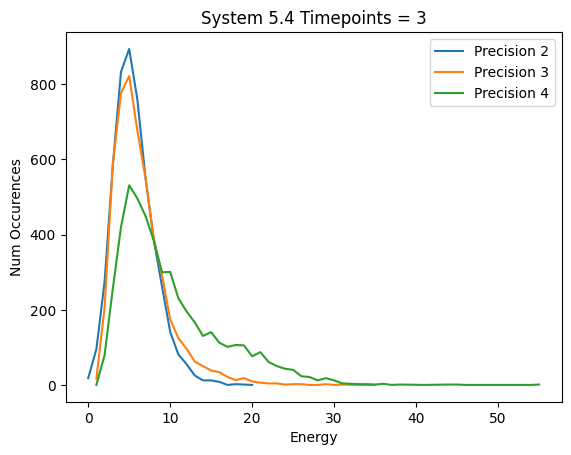

In [77]:
for p in [2,3,4]:
    df = dfs_grouped_rounded['5.4',p,3].reset_index()
    plt.plot(df['energy'], df['num_occurrences'],label=f"Precision {p}")

plt.xlabel('Energy')
plt.ylabel('Num Occurences')
plt.title("System 5.4 Timepoints = 3")
plt.legend()


# Simplification ?

In [61]:
dfs_not_pruned = load_data(pruned=False,precision_range=(2,3))
dfs_not_pruned

,energy,num_occurrences,systemid,precision,timepoints
0,1.0,1,5.4,2,3
1,1.0,1,5.4,2,3
2,1.0,1,5.4,2,3
3,2.0,1,5.4,2,3
4,2.0,1,5.4,2,3
...,...,...,...,...,...
995,20.0,1,5.4,2,5
996,29.0,1,5.4,2,5
997,22.0,1,5.4,2,5
998,52.0,1,5.4,2,5


In [64]:
dfs_not_pruned['energy'] = round(dfs_not_pruned['energy'] +0.499) # for displaying in a histogram
dfs_not_pruned = dfs_not_pruned.groupby(['systemid', 'precision','timepoints','energy'])['num_occurrences'].sum()
dfs_not_pruned

systemid  precision  timepoints  energy
5.4       2          3           0.0         2
                                 1.0        26
                                 2.0        86
                                 3.0       221
                                 4.0       344
                                          ... 
                     5           54.0        4
                                 57.0        1
                                 58.0        1
                                 60.0        1
                                 64.0        1
Name: num_occurrences, Length: 136, dtype: int64

(0.0, 10.0)

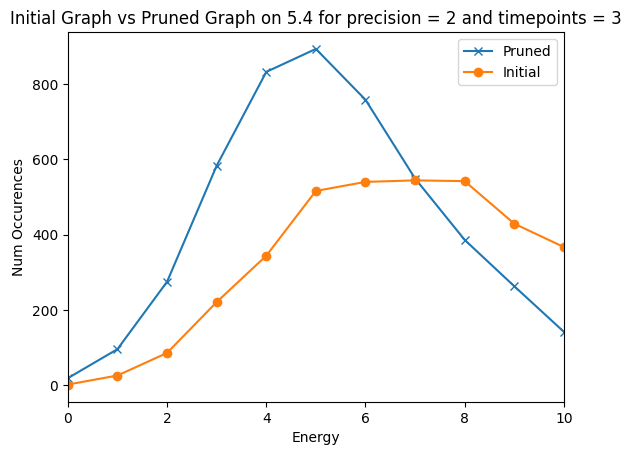

In [75]:
#plt.plot(dfs_not_pruned['energy'],dfs_not_pruned['num_occurrences'],label="Full graph",marker='o')
plt.plot(dfs_grouped['5.4',2,3],label="Pruned",marker='x')
plt.plot(dfs_not_pruned['5.4',2,3],label="Initial",marker='o')

plt.xlabel('Energy')
plt.title("Initial Graph vs Pruned Graph on 5.4 for precision = 2 and timepoints = 3")
plt.ylabel('Num Occurences')
plt.legend()

plt.xlim(0,10)

-more qubits
-pt symmetric eq 12 paper
- include specific machine